In [9]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from CustomModels import BetaRegression, LinearLimitedRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [10]:
dateparse = lambda x: datetime.strptime(x, '%Y/%m/%d') if isinstance(x, str) else x

In [11]:
# Load the data
data = pd.read_excel('SignedPlayersDatasetVALORANT.xlsx', parse_dates=['date'], date_parser=dateparse)
# Fix name errors
data = data.replace('\n','', regex=True)
data = data.replace(' ','', regex=True)
#test_data = pd.read_excel('Test Dataset VALORANT VCT DATASET.xlsx', parse_dates=['date'], date_parser=dateparse).dropna(how='any',axis=0)

In [27]:
# Select features and target variable
input_features = ['date', 'player']
#features = ['kills_per_round', 'assists_per_round', 'average_damage_per_round',
#            'first_kills_per_round', 'first_deaths_per_round', 'headshot_percentage',
#            'clutch_success_percentage', 'total_kills', 'total_deaths', 'total_assists',
#            'total_first_kills', 'total_first_deaths']
features = ['kills_per_round', 'assists_per_round', 'average_damage_per_round',
            'first_kills_per_round', 'clutch_success_percentage', 'headshot_percentage']
target_variable = 'average_combat_score'
#Note: create models w/ target variable for rounds and rating

In [28]:
# Get dates and players
dates = data['date'].unique()
players = data['player'].unique()

In [29]:
dates

array(['2022-10-07T00:00:00.000000000', '2022-08-31T00:00:00.000000000',
       '2023-02-13T00:00:00.000000000', '2021-09-19T00:00:00.000000000',
       '2023-11-06T00:00:00.000000000', '2023-06-08T00:00:00.000000000',
       '2021-12-12T00:00:00.000000000', '2021-05-30T00:00:00.000000000',
       '2022-10-04T00:00:00.000000000'], dtype='datetime64[ns]')

In [30]:
# For getting difference in months
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def months_from_2021(dates):
    months_from_Jan_2021 = []
    for date in dates:
        months_from_Jan_2021.append(diff_month(date, datetime.strptime('2021/01/01', '%Y/%m/%d')))
    return months_from_Jan_2021

In [31]:
data = data.assign(months_from_Jan_2021 = months_from_2021(data['date']))

In [43]:
#Load models

ACS_model_file_name = 'model new.sav'
feature_model_tree_file_name = 'player_feature_models.sav'
feature_model_linear_file_name = 'player_feature_models_linear.sav'
feature_model_xgb_file_name = 'player_feature_models_XGB.sav'
feature_model_beta_file_name = 'player_feature_models_beta.sav'
feature_model_linear_limited_file_name = 'player_feature_models_linear_limited.sav'

model = pickle.load(open(ACS_model_file_name, 'rb'))
player_feature_models_tree = pickle.load(open(feature_model_tree_file_name, 'rb'))
player_feature_models_linear = pickle.load(open(feature_model_linear_file_name, 'rb'))
player_feature_models_XGB = pickle.load(open(feature_model_xgb_file_name, 'rb'))
player_feature_models_beta = pickle.load(open(feature_model_beta_file_name, 'rb'))
player_feature_models_linear_limited = pickle.load(open(feature_model_linear_limited_file_name, 'rb'))

feature_models = player_feature_models_linear

In [33]:
#Predict Functions

In [34]:
def predict_player_feature(player, date, feature):
    date_array = [dateparse(date)]
    date_from_Jan_2021 = months_from_2021(date_array)
    if feature_models != player_feature_models_beta:
        date_from_Jan_2021 = np.array([date_from_Jan_2021])
    else:
        date_from_Jan_2021.append(10.1)
        #date_from_Jan_2021 = pd.DataFrame({'date_from_Jan_2021':date_from_Jan_2021})
    return feature_models.get(player).get(feature).predict(date_from_Jan_2021)[0]

In [35]:
def predict_players_values(players_and_dates):
    players_and_dates = players_and_dates.assign(months_from_Jan_2021 = months_from_2021(players_and_dates['date']))
    player_predicted_values = pd.DataFrame()
    for feature in features:
        player_values = []
        for player_and_date in players_and_dates.itertuples():
            player_values.append(predict_player_feature(player_and_date.player, player_and_date.date, feature))
        player_predicted_values[feature] = player_values
    return pd.DataFrame(player_predicted_values)

In [36]:
#Predict ACS
def predictACS(players_and_dates):
    return model.predict(predict_players_values(players_and_dates))

In [37]:
#Player predictions on date
#Note: Use pandas dataframe on this. 
def playerStatPredictions(players_and_dates):
    players_predictions = players_and_dates.copy()
    players_predictions = pd.merge(players_predictions, predict_players_values(players_and_dates), left_index=True, right_index=True)
    players_predictions['average_combat_score'] = predictACS(players_and_dates)
    return players_predictions

In [38]:
#Get all players in dates
def all_players_date(dates_used):
    index = pd.MultiIndex.from_product([players, dates_used], names = ["player", "date"])
    players_dates_pd = pd.DataFrame(index = index).reset_index()
    players_dates_pd['date'] = pd.to_datetime(players_dates_pd['date'])
    return players_dates_pd

In [39]:
#Test models
def test_model():
    model_mse = pd.DataFrame()
    prediction_features = predict_players_values(data[['player', 'date']])
    prediction_ACS = predictACS(data[['player', 'date']])
    model_mse['ACS_mse'] = [mean_squared_error(data['average_combat_score'], prediction_ACS)]
    model_mse['ACS_mape'] = [mean_absolute_percentage_error(data['average_combat_score'], prediction_ACS)]
    model_mse['ACS_r2'] = [r2_score(data['average_combat_score'], prediction_ACS)]
    for feature in features:
        model_mse[feature + '_mse'] = [mean_squared_error(data[feature], prediction_features[feature])]
        model_mse[feature + '_mape'] = [mean_absolute_percentage_error(data[feature], prediction_features[feature])]
        model_mse[feature + '_r2'] = [r2_score(data[feature], prediction_features[feature])]
    return model_mse

In [44]:
feature_models = player_feature_models_tree
test_model()

,ACS_mse,ACS_mape,ACS_r2,kills_per_round_mse,kills_per_round_mape,kills_per_round_r2,assists_per_round_mse,assists_per_round_mape,assists_per_round_r2,average_damage_per_round_mse,...,average_damage_per_round_r2,first_kills_per_round_mse,first_kills_per_round_mape,first_kills_per_round_r2,clutch_success_percentage_mse,clutch_success_percentage_mape,clutch_success_percentage_r2,headshot_percentage_mse,headshot_percentage_mape,headshot_percentage_r2
0,63.024998,0.027675,0.936883,0.000474,0.012283,0.963268,0.000245,0.0225,0.97846,16.852039,...,0.957459,0.000058,0.030464,0.987106,0.000753,8.475674e+12,0.926252,0.000078,0.013312,0.974029


In [45]:
feature_models = player_feature_models_linear
test_model()

,ACS_mse,ACS_mape,ACS_r2,kills_per_round_mse,kills_per_round_mape,kills_per_round_r2,assists_per_round_mse,assists_per_round_mape,assists_per_round_r2,average_damage_per_round_mse,...,average_damage_per_round_r2,first_kills_per_round_mse,first_kills_per_round_mape,first_kills_per_round_r2,clutch_success_percentage_mse,clutch_success_percentage_mape,clutch_success_percentage_r2,headshot_percentage_mse,headshot_percentage_mape,headshot_percentage_r2
0,273.654165,0.065063,0.725946,0.003194,0.062524,0.752426,0.002573,1.004233e+12,0.773825,92.516963,...,0.766454,0.00112,2.880449e+12,0.749522,0.004724,4.701643e+13,0.537062,0.000752,0.076744,0.748224


In [46]:
feature_models = player_feature_models_XGB
test_model()

,ACS_mse,ACS_mape,ACS_r2,kills_per_round_mse,kills_per_round_mape,kills_per_round_r2,assists_per_round_mse,assists_per_round_mape,assists_per_round_r2,average_damage_per_round_mse,...,average_damage_per_round_r2,first_kills_per_round_mse,first_kills_per_round_mape,first_kills_per_round_r2,clutch_success_percentage_mse,clutch_success_percentage_mape,clutch_success_percentage_r2,headshot_percentage_mse,headshot_percentage_mape,headshot_percentage_r2
0,55.357023,0.025251,0.944562,0.000365,0.009679,0.971668,0.000181,1.731347e+10,0.984057,13.572597,...,0.965738,0.000044,1.095412e+11,0.990172,0.000633,6.918765e+12,0.937933,0.000064,0.012678,0.978737


In [ ]:
#Broken
#feature_models = player_feature_models_beta
#test_model()

In [48]:
feature_models = player_feature_models_linear_limited
test_model()

,ACS_mse,ACS_mape,ACS_r2,kills_per_round_mse,kills_per_round_mape,kills_per_round_r2,assists_per_round_mse,assists_per_round_mape,assists_per_round_r2,average_damage_per_round_mse,...,average_damage_per_round_r2,first_kills_per_round_mse,first_kills_per_round_mape,first_kills_per_round_r2,clutch_success_percentage_mse,clutch_success_percentage_mape,clutch_success_percentage_r2,headshot_percentage_mse,headshot_percentage_mape,headshot_percentage_r2
0,273.654165,0.065063,0.725946,0.003194,0.062524,0.752426,0.002573,1.004233e+12,0.773825,92.516963,...,0.766454,0.001056,2.880449e+12,0.763819,0.004705,4.581430e+13,0.538925,0.000752,0.076744,0.748224


In [49]:
feature_models = player_feature_models_linear_limited

In [50]:
prediction_ACS = predictACS(data[['player', 'date']])

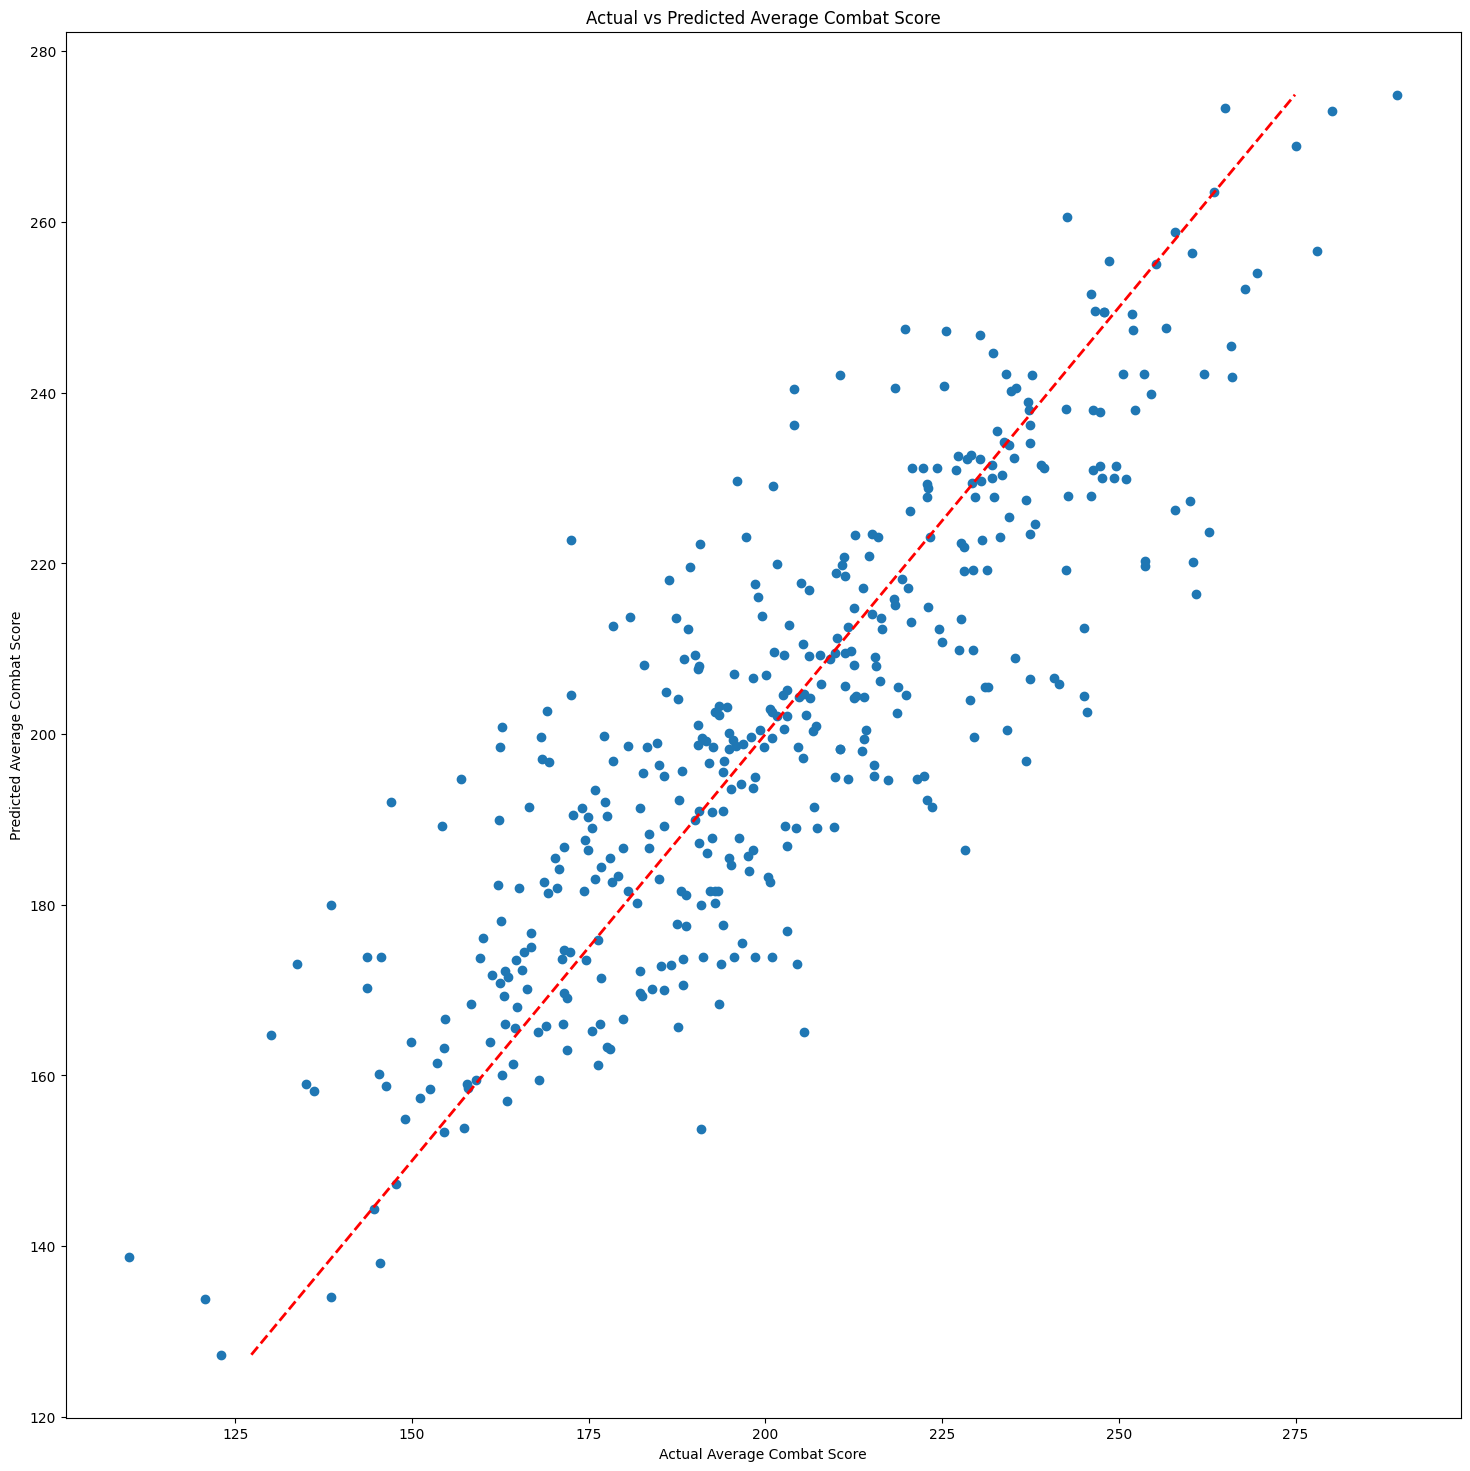

In [51]:
# Actual vs Predicted graph

# Create a larger figure
plt.figure(figsize=(18, 18))

# Plot actual vs predicted values with player names
plt.scatter(data['average_combat_score'], prediction_ACS)
plt.plot([min(prediction_ACS), max(prediction_ACS)], [min(prediction_ACS), max(prediction_ACS)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Actual Average Combat Score")
plt.ylabel("Predicted Average Combat Score")
plt.title("Actual vs Predicted Average Combat Score")

plt.show()

In [52]:
#Predict Missing values
all_players_dates_pd = all_players_date(dates)
all_data = all_players_dates_pd.merge(data, on=['player', 'date'], how='left')
missing_data = all_data[pd.isna(all_data['average_combat_score'])].reset_index(drop=True)
missing_data_predict = playerStatPredictions(missing_data[['player', 'date']])
all_data = all_data.set_index(['player', 'date']).combine_first(missing_data_predict.set_index(['player', 'date'])).reset_index()

In [53]:
all_data

,player,date,assists_per_round,average_combat_score,average_damage_per_round,clutch_success_percentage,first_deaths_per_round,first_kills_per_round,headshot_percentage,kills_deaths,kills_per_round,months_from_Jan_2021,rating,rounds,total_assists,total_deaths,total_first_deaths,total_first_kills,total_kills
0,ANGE1,2021-05-30,0.143315,171.379105,115.634239,0.066359,NaN,0.061739,0.355815,NaN,0.626739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANGE1,2021-09-19,0.180109,170.849197,115.594565,0.071848,NaN,0.069565,0.345109,NaN,0.619565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ANGE1,2021-12-12,0.207704,171.042801,115.564810,0.075965,NaN,0.075435,0.337079,NaN,0.614185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ANGE1,2022-08-31,0.280000,159.600000,106.500000,0.100000,0.15,0.080000,0.310000,0.68,0.530000,19.0,0.75,357.0,99.0,276.0,53.0,27.0,189.0
4,ANGE1,2022-10-04,0.299687,174.486328,115.465625,0.089688,NaN,0.095000,0.310312,NaN,0.596250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,zekken,2022-10-04,0.228571,205.917603,137.064286,0.085000,NaN,0.135714,0.236429,NaN,0.704286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
896,zekken,2022-10-07,0.220000,241.600000,158.000000,0.070000,0.14,0.140000,0.230000,1.11,0.820000,21.0,1.09,119.0,26.0,87.0,17.0,17.0,97.0
897,zekken,2023-02-13,0.280000,138.500000,77.300000,0.000000,0.13,0.100000,0.240000,0.47,0.380000,25.0,0.60,39.0,10.0,30.0,4.0,1.0,16.0
898,zekken,2023-06-08,0.325714,124.785767,65.520000,0.000000,NaN,0.067143,0.239286,NaN,0.333000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
all_players_dates_pd = all_players_date(dates)

In [55]:
model_predict = playerStatPredictions(all_players_dates_pd)

In [56]:
#Other graphs

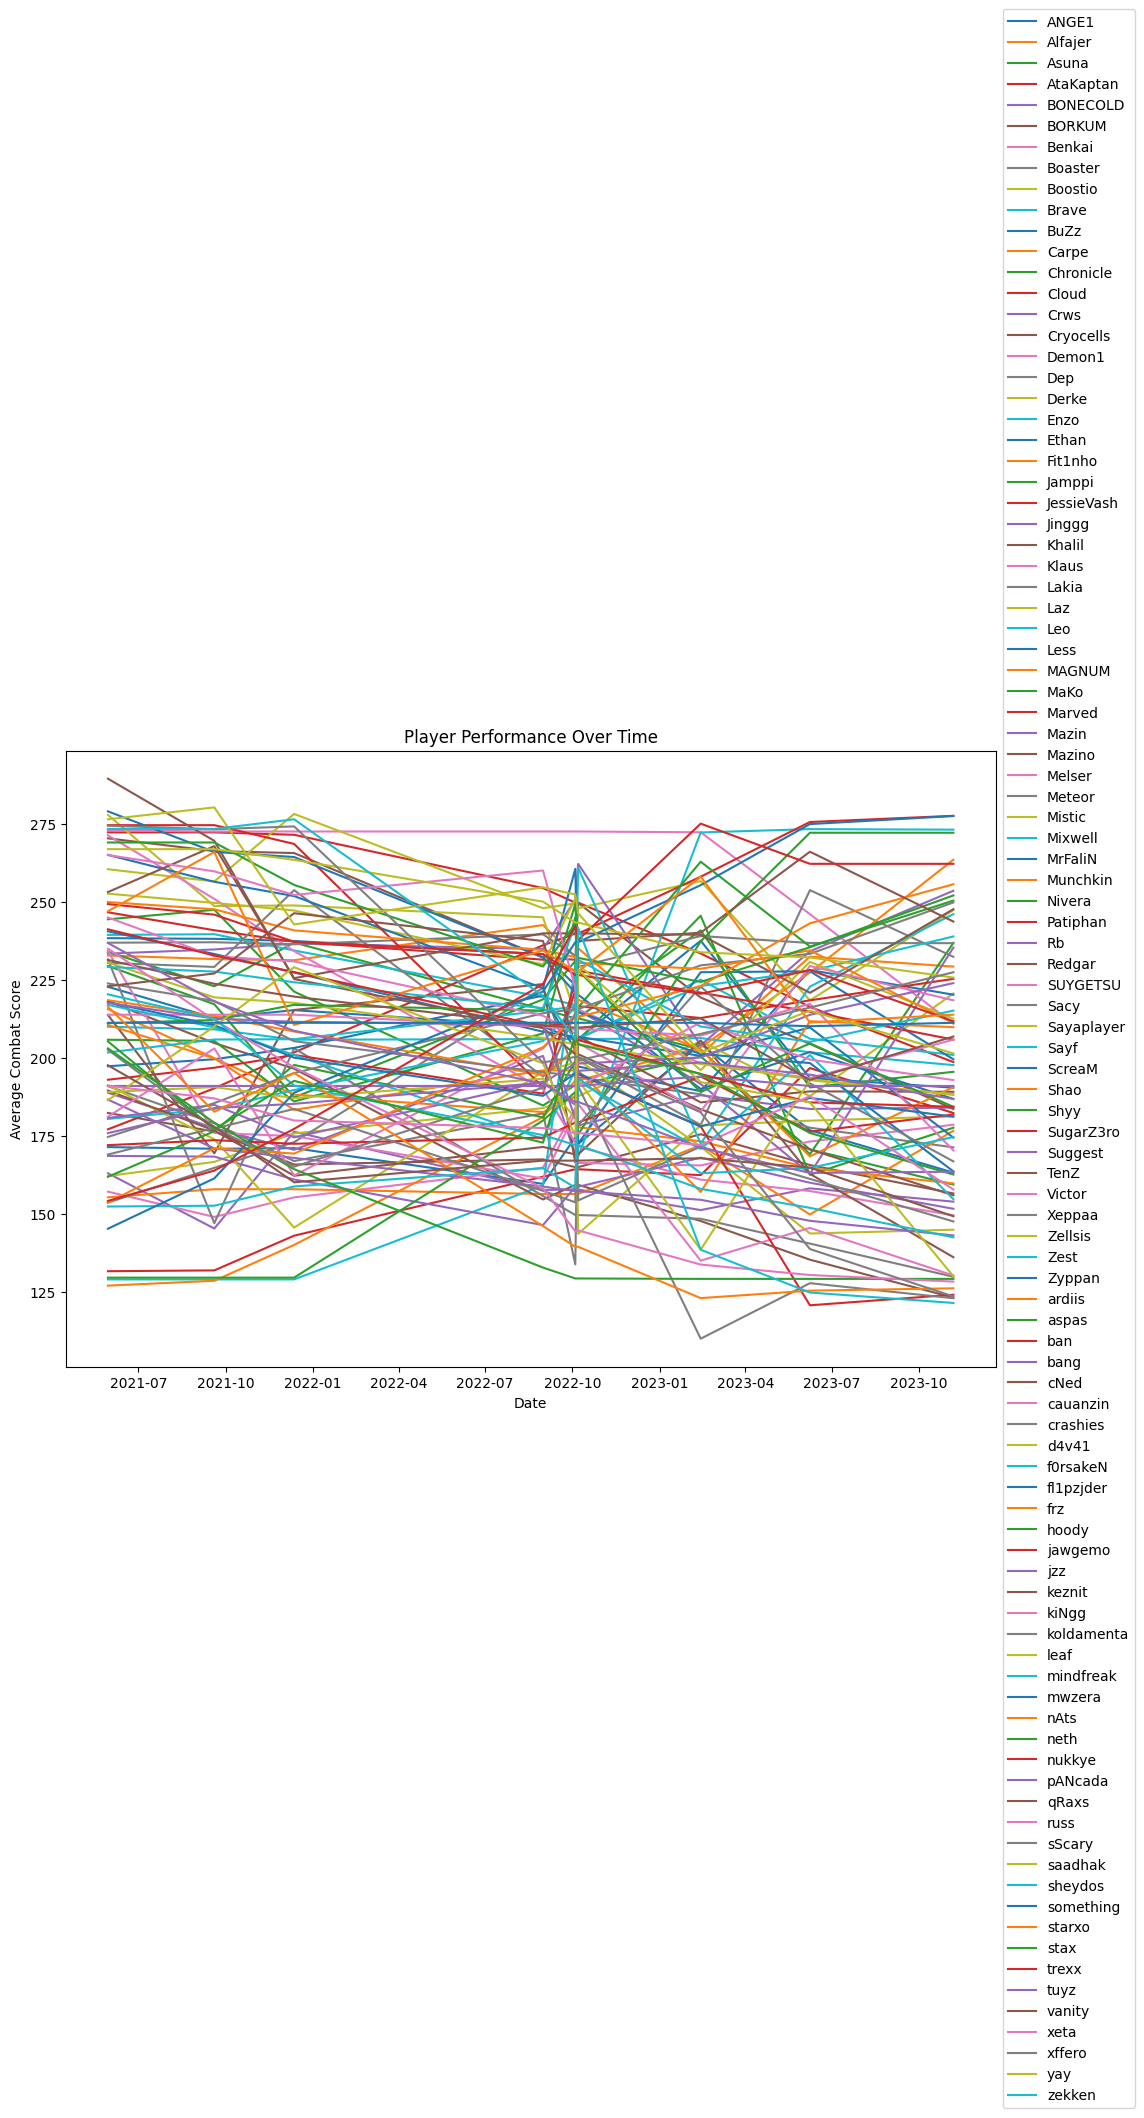

In [57]:
# Plot of all player performance over time

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in all_data.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [58]:
# Plot of top 5 player performance over time

In [59]:
#Get top 5 players with ACS from this period
top_ACS_players = data.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')
top_5_ACS_players = top_ACS_players[['player', 'average_combat_score']].head(5)

In [60]:
top_5_ACS_players

,player,average_combat_score
118,TenZ,289.4
409,yay,280.2
152,Derke,278.1
207,trexx,275.0
176,cNed,267.8


In [61]:
top_5_ACS_players_data = all_data.loc[all_data['player'].isin(top_5_ACS_players['player'])]

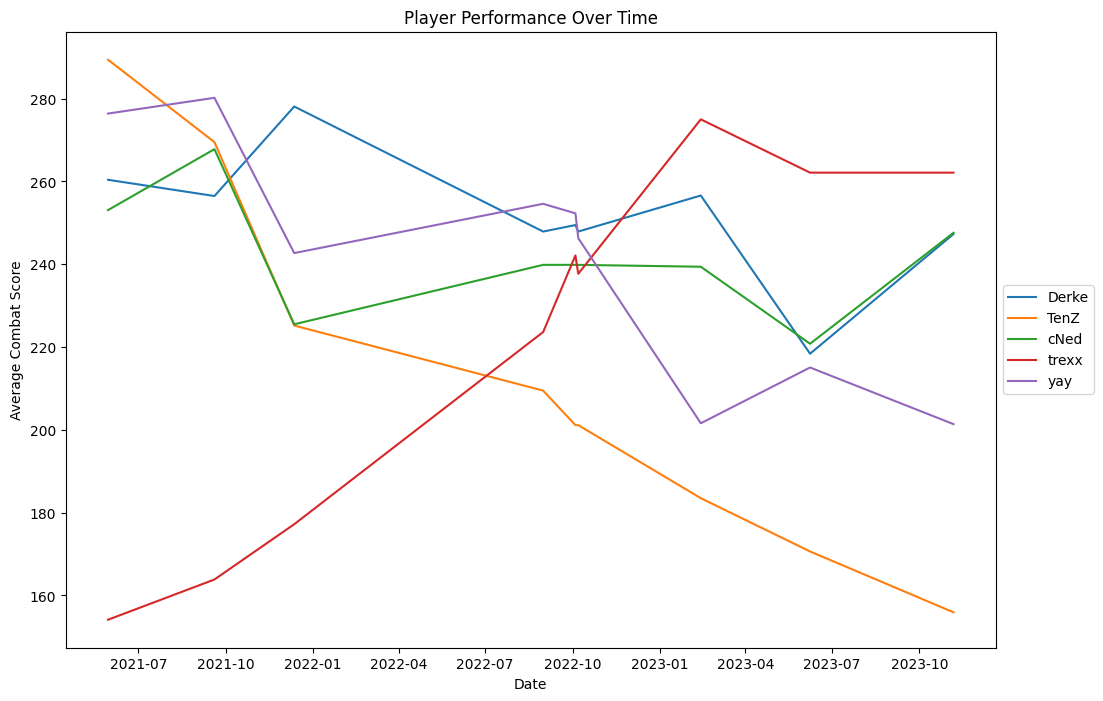

In [62]:
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in top_5_ACS_players_data.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [63]:
#Get ACS and stats of players at next tournament date
next_tourney_date = '2024/1/23'
players_tournament = pd.DataFrame({'player':players, 'date':next_tourney_date})
players_tournament['date'] = pd.to_datetime(players_tournament['date'])

In [64]:
players_tournament = playerStatPredictions(players_tournament)

In [65]:
#Top 10 players next tournament
players_tournament.sort_values('average_combat_score', ascending=False).head(10)

,player,date,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,clutch_success_percentage,headshot_percentage,average_combat_score
8,mwzera,2024-01-23,1.122000,0.406429,199.320000,0.121429,0.314286,0.239286,277.440155
93,JessieVash,2024-01-23,1.120000,0.265000,190.057143,0.117857,0.000000,0.357143,275.051941
63,Enzo,2024-01-23,1.122000,0.000000,199.320000,0.412500,0.290000,0.305000,273.074188
12,Shyy,2024-01-23,1.122000,0.000000,199.320000,0.366429,0.038214,0.127143,272.203033
46,Fit1nho,2024-01-23,0.932500,0.190000,183.100000,0.207500,0.605000,0.167500,264.227631
51,trexx,2024-01-23,1.122000,0.000000,199.320000,0.000000,0.000000,0.550000,262.126923
21,frz,2024-01-23,0.932653,0.344082,174.361224,0.091224,0.000000,0.402857,258.893768
48,Nivera,2024-01-23,0.932885,0.311346,155.380769,0.990000,0.055192,0.295385,252.829208
4,Xeppaa,2024-01-23,1.042857,0.240714,144.621429,0.115714,0.693000,0.277143,252.163986
14,aspas,2024-01-23,0.859039,0.178129,161.487159,0.217846,0.084833,0.280485,249.225800


In [66]:
#Get ACS and stats of players at next tournaments
future_dates = ['2024-01-23', '2024-03-15', '2024-04-01']

In [67]:
multiple_player_tournament = playerStatPredictions(all_players_date(future_dates))

In [68]:
multiple_player_tournament

,player,date,kills_per_round,assists_per_round,average_damage_per_round,first_kills_per_round,clutch_success_percentage,headshot_percentage,average_combat_score
0,Cryocells,2024-01-23,0.553571,0.480714,123.582143,0.040714,0.000000,0.099000,176.713013
1,Cryocells,2024-03-15,0.515000,0.525000,120.375000,0.025000,0.000000,0.099000,174.287277
2,Cryocells,2024-04-01,0.495714,0.547143,118.771429,0.017143,0.000000,0.099000,172.567566
3,bang,2024-01-23,0.795000,0.303333,144.400000,0.240000,0.000000,0.371667,224.234848
4,bang,2024-03-15,0.805000,0.296667,146.200000,0.260000,0.000000,0.368333,224.630402
...,...,...,...,...,...,...,...,...,...
295,yay,2024-03-15,0.710905,0.130959,114.860015,0.125785,0.000000,0.279969,187.952057
296,yay,2024-04-01,0.702900,0.130681,112.839366,0.122815,0.000000,0.281268,185.738586
297,hoody,2024-01-23,0.551667,0.526667,120.508333,0.065833,0.084167,0.157083,180.209152
298,hoody,2024-03-15,0.521667,0.566667,116.358333,0.060833,0.069167,0.139583,169.547638


In [69]:
#Top 10 players at the next 3 tournaments
multiple_player_tournament[['player', 'date', 'average_combat_score']].sort_values('average_combat_score', ascending=False).head(10)

,player,date,average_combat_score
26,mwzera,2024-04-01,277.440155
25,mwzera,2024-03-15,277.440155
24,mwzera,2024-01-23,277.440155
139,Fit1nho,2024-03-15,276.421753
140,Fit1nho,2024-04-01,276.421753
279,JessieVash,2024-01-23,275.051941
280,JessieVash,2024-03-15,273.965546
281,JessieVash,2024-04-01,273.965546
190,Enzo,2024-03-15,273.074188
191,Enzo,2024-04-01,273.074188


In [70]:
#Get top 5 players with ACS from this period
top_ACS_players_next = multiple_player_tournament.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')
top_5_ACS_players_next = top_ACS_players_next[['player', 'average_combat_score']].head(5)

In [71]:
top_5_ACS_players_next

,player,average_combat_score
26,mwzera,277.440155
139,Fit1nho,276.421753
279,JessieVash,275.051941
190,Enzo,273.074188
36,Shyy,272.203033


In [72]:
top_5_ACS_players_next_data = multiple_player_tournament.loc[multiple_player_tournament['player'].isin(top_5_ACS_players['player'])]

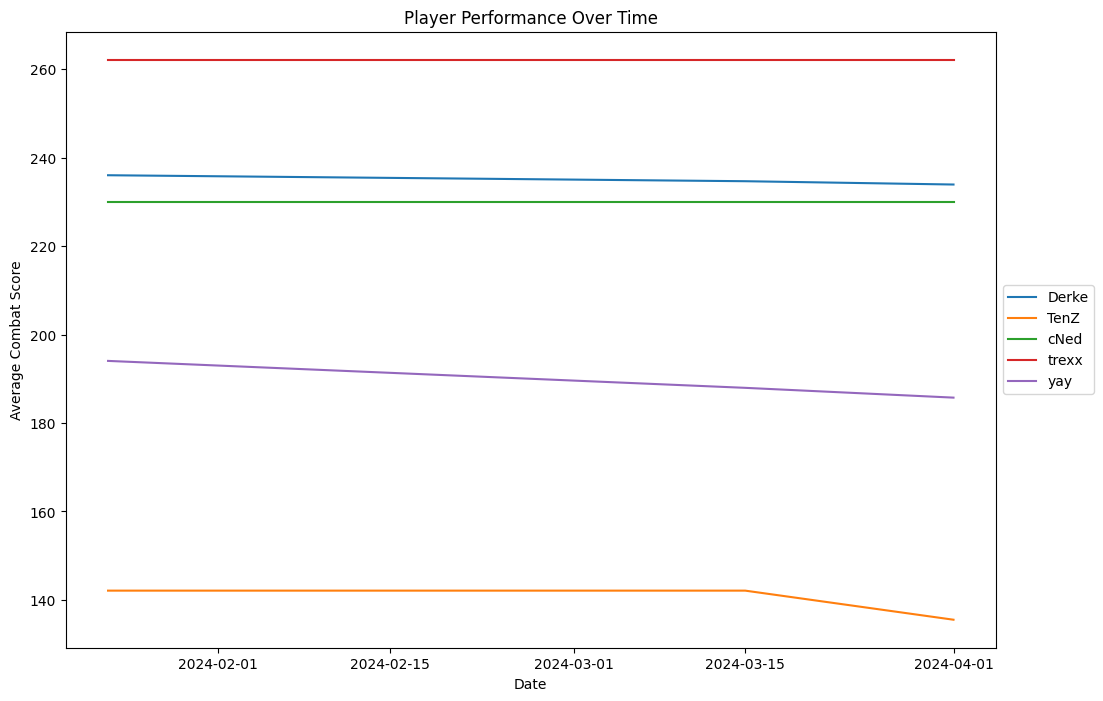

In [73]:
#Plot performance
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in top_5_ACS_players_next_data.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [74]:
#Join two models
all_data_extend = pd.concat([all_data, multiple_player_tournament])

In [75]:
all_data_extend

,player,date,assists_per_round,average_combat_score,average_damage_per_round,clutch_success_percentage,first_deaths_per_round,first_kills_per_round,headshot_percentage,kills_deaths,kills_per_round,months_from_Jan_2021,rating,rounds,total_assists,total_deaths,total_first_deaths,total_first_kills,total_kills
0,ANGE1,2021-05-30,0.143315,171.379105,115.634239,0.066359,NaN,0.061739,0.355815,NaN,0.626739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ANGE1,2021-09-19,0.180109,170.849197,115.594565,0.071848,NaN,0.069565,0.345109,NaN,0.619565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ANGE1,2021-12-12,0.207704,171.042801,115.564810,0.075965,NaN,0.075435,0.337079,NaN,0.614185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ANGE1,2022-08-31,0.280000,159.600000,106.500000,0.100000,0.15,0.080000,0.310000,0.68,0.530000,19.0,0.75,357.0,99.0,276.0,53.0,27.0,189.0
4,ANGE1,2022-10-04,0.299687,174.486328,115.465625,0.089688,NaN,0.095000,0.310312,NaN,0.596250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,yay,2024-03-15,0.130959,187.952057,114.860015,0.000000,NaN,0.125785,0.279969,NaN,0.710905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,yay,2024-04-01,0.130681,185.738586,112.839366,0.000000,NaN,0.122815,0.281268,NaN,0.702900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,hoody,2024-01-23,0.526667,180.209152,120.508333,0.084167,NaN,0.065833,0.157083,NaN,0.551667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
298,hoody,2024-03-15,0.566667,169.547638,116.358333,0.069167,NaN,0.060833,0.139583,NaN,0.521667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


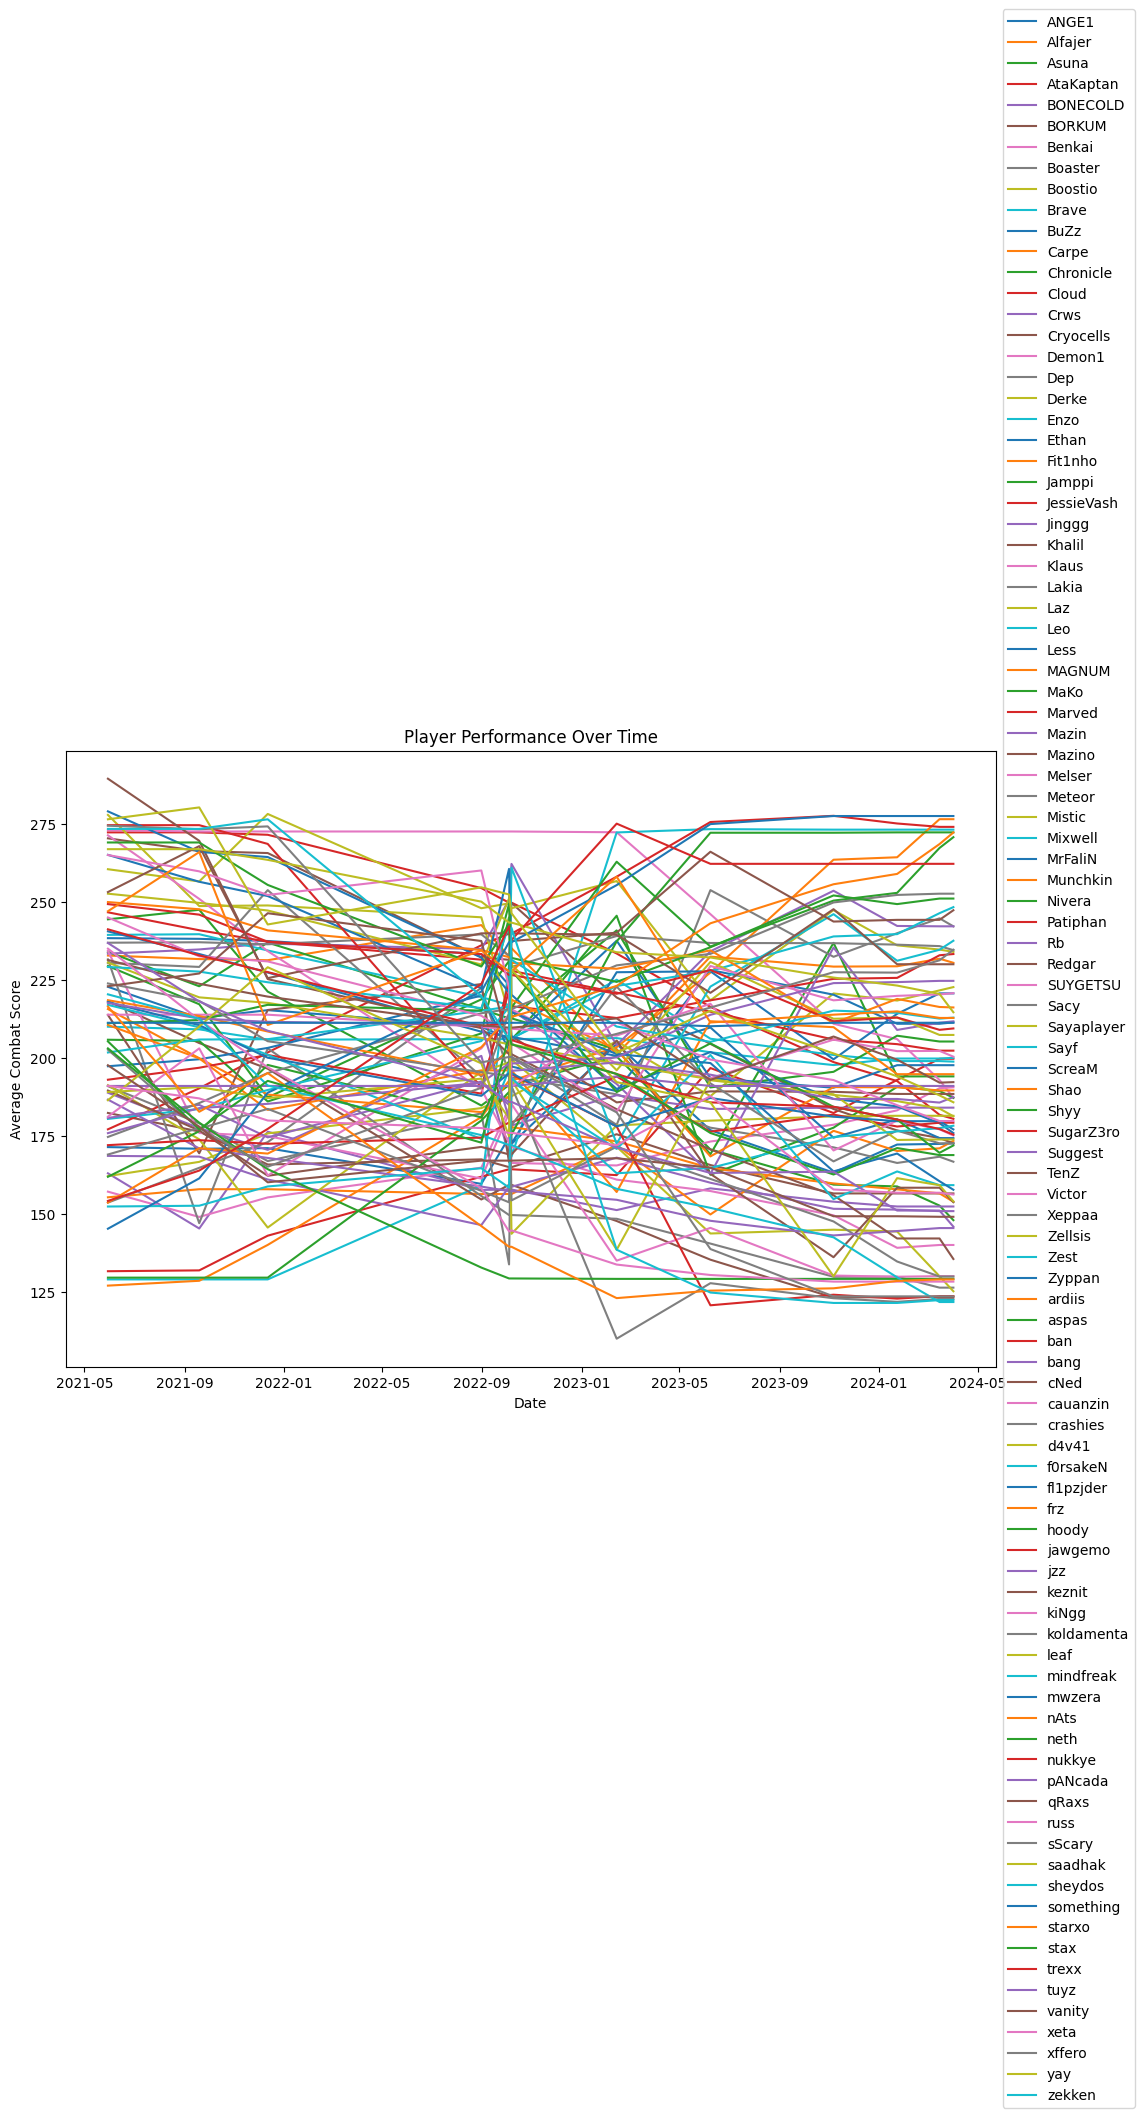

In [76]:
# Plot of all player performance over time

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in all_data_extend.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [77]:
#Get top 10 players with ACS from this period
top_ACS_players_all = all_data_extend.sort_values('average_combat_score', ascending=False).drop_duplicates(subset='player', keep='first')
top_10_ACS_players_all = top_ACS_players_all[['player', 'average_combat_score']].head(10)

In [78]:
top_10_ACS_players_all

,player,average_combat_score
495,TenZ,289.400000
883,yay,280.200000
540,Zyppan,278.936218
164,Derke,278.100000
252,Laz,277.794495
215,JessieVash,277.508057
26,mwzera,277.440155
140,Fit1nho,276.421753
893,zekken,276.396301
843,trexx,275.000000


In [79]:
top_10_ACS_players_data_all = all_data_extend.loc[all_data_extend['player'].isin(top_10_ACS_players_all['player'])]

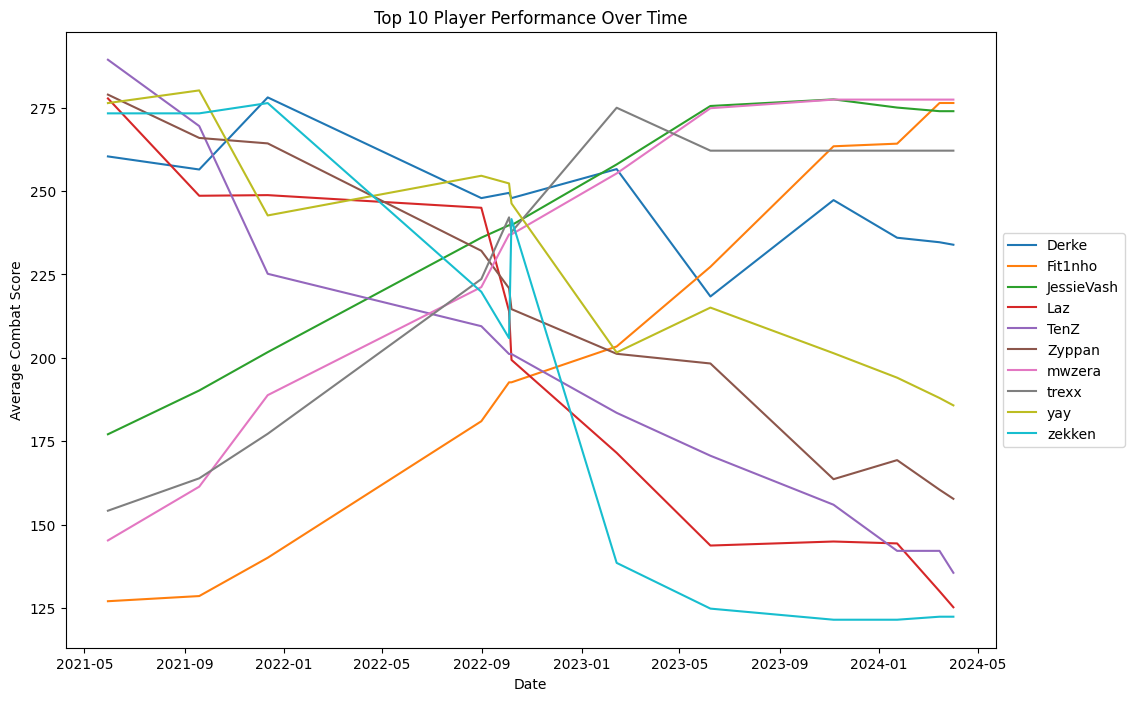

In [80]:
#Plot performance
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the performance of players from every tournament
for player_name, player_data in top_10_ACS_players_data_all.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Top 10 Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [81]:
#Get top 10 players with ACS at final date
top_ACS_players_all = all_data_extend.loc[all_data_extend['date'] == '2024-04-01'].sort_values('average_combat_score', ascending=False)
top_10_ACS_players_all = top_ACS_players_all[['player', 'average_combat_score']].head(10)

In [82]:
top_10_ACS_players_all

,player,average_combat_score
26,mwzera,277.440155
140,Fit1nho,276.421753
281,JessieVash,273.965546
191,Enzo,273.074188
38,Shyy,272.203033
65,frz,272.161743
146,Nivera,270.658844
155,trexx,262.126923
14,Xeppaa,252.559540
44,aspas,251.001709


In [83]:
top_10_ACS_players_all

,player,average_combat_score
26,mwzera,277.440155
140,Fit1nho,276.421753
281,JessieVash,273.965546
191,Enzo,273.074188
38,Shyy,272.203033
65,frz,272.161743
146,Nivera,270.658844
155,trexx,262.126923
14,Xeppaa,252.559540
44,aspas,251.001709


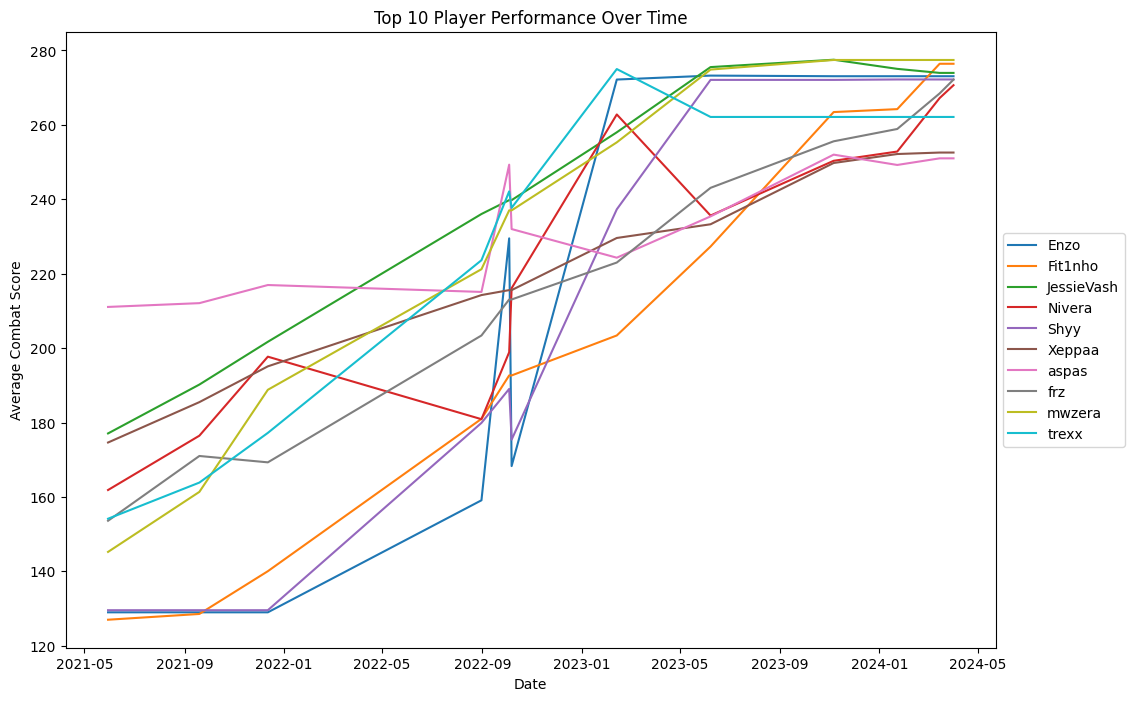

In [84]:
#Plot performance
# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 8))

top_10_ACS_players_data_all = all_data_extend.loc[all_data_extend['player'].isin(top_10_ACS_players_all['player'])]

# Plotting the performance of players from every tournament
for player_name, player_data in top_10_ACS_players_data_all.groupby('player'):
    ax.plot(player_data['date'], player_data['average_combat_score'], label=player_name)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Average Combat Score')
ax.set_title('Top 10 Player Performance Over Time')

# Move the legend outside the plot box
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

In [85]:
feature_models = player_feature_models_beta
predict_player_feature('TenZ', pd.to_datetime(dates[1]), 'kills_per_round')

0.73634

In [86]:
date_ex = months_from_2021(pd.to_datetime(dates))

In [87]:
np.array(date_ex)

array([21, 19, 25,  8, 34, 29, 11,  4, 21])

In [88]:
feature_models = player_feature_models_linear
feature_models.get('TenZ').get('kills_per_round')

LinearRegression()

In [89]:
data['months_from_Jan_2021'].values[:,np.newaxis]

array([[21],
       [19],
       [25],
       [19],
       [25],
       [ 8],
       [19],
       [25],
       [25],
       [34],
       [29],
       [11],
       [25],
       [ 4],
       [11],
       [25],
       [25],
       [34],
       [29],
       [11],
       [19],
       [25],
       [11],
       [25],
       [ 4],
       [ 8],
       [11],
       [21],
       [21],
       [19],
       [29],
       [21],
       [19],
       [25],
       [29],
       [ 8],
       [11],
       [21],
       [21],
       [19],
       [29],
       [21],
       [19],
       [25],
       [ 4],
       [ 8],
       [11],
       [21],
       [21],
       [19],
       [25],
       [21],
       [21],
       [19],
       [25],
       [34],
       [29],
       [21],
       [19],
       [25],
       [ 4],
       [11],
       [21],
       [21],
       [19],
       [25],
       [34],
       [29],
       [21],
       [21],
       [19],
       [25],
       [34],
       [29],
       [21],
       [25],
       [34],

In [90]:
prediction_data_all = feature_models.get('TenZ').get('kills_per_round').predict(np.array(date_ex)[:,np.newaxis])

In [91]:
prediction_data_all

array([0.70458, 0.73634, 0.64106, 0.91102, 0.49814, 0.57754, 0.86338,
       0.97454, 0.70458])

In [92]:
feature_models = player_feature_models_beta
feature_models.get('TenZ').get('kills_per_round')

In [93]:
np.array([np.array(date_ex)[0]])

array([21])

In [94]:
prediction_data_all = feature_models.get('TenZ').get('kills_per_round').predict(np.array(date_ex))

In [95]:
prediction_data_all = feature_models.get('TenZ').get('kills_per_round').predict(np.array([np.array(date_ex)[0]]))

ValueError: shapes (1,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

In [ ]:
prediction_data_all

In [ ]:
pd.to_datetime(dates[0])

In [ ]:
feature_models = player_feature_models_linear
predict_player_feature('TenZ', pd.to_datetime(dates[0]), 'kills_per_round')